#### Preprocessing

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
tf.__version__

'2.0.0'

from zipfile import ZipFile
zip_file = ZipFile('all.zip', 'r')
zip_file.extractall('data')

import os
os.listdir('data')[:3]

from zipfile import ZipFile
for file in os.listdir('data'):
    zip_file = ZipFile('data/'+file, 'r')
    zip_file.extractall('unzipped_data')

len(os.listdir('unzipped_data'))

#### Extracting labels

os.remove('unzipped_data/B_02_-+60.Jpg')

In [4]:
from tqdm import tqdm
import os
image_id=[]
angle=[]
for i in tqdm(os.listdir('unzipped_data')):
    if i !='Thumbs.db':
        image_id.append(i)
        ang=int(i.split('_')[2].split('.')[0])
        angle.append(ang)

100%|██████████████████████████████████████████████████████████████████████████| 6623/6623 [00:00<00:00, 951135.91it/s]


#### Creating dataframe

In [5]:
import pandas as pd

image_data = {'image_id' : image_id,'angle':angle}

image_data= pd.DataFrame(image_data) 

In [6]:
image_data.head()

,image_id,angle
0,A_01_+05.Jpg,5
1,A_01_+10.Jpg,10
2,A_01_+15.Jpg,15
3,A_01_+20.Jpg,20
4,A_01_+25.Jpg,25


In [7]:
image_data.shape

(6622, 2)

#### Displaying a sample image

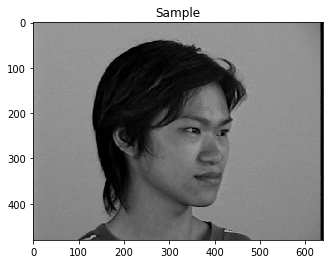

In [8]:
from matplotlib import pyplot as plt
import cv2
img = cv2.imread('unzipped_data/A_01_+45.Jpg')
plt.imshow(img)
plt.title('Sample')
plt.show()

In [9]:
image_data.iloc[0].angle

5

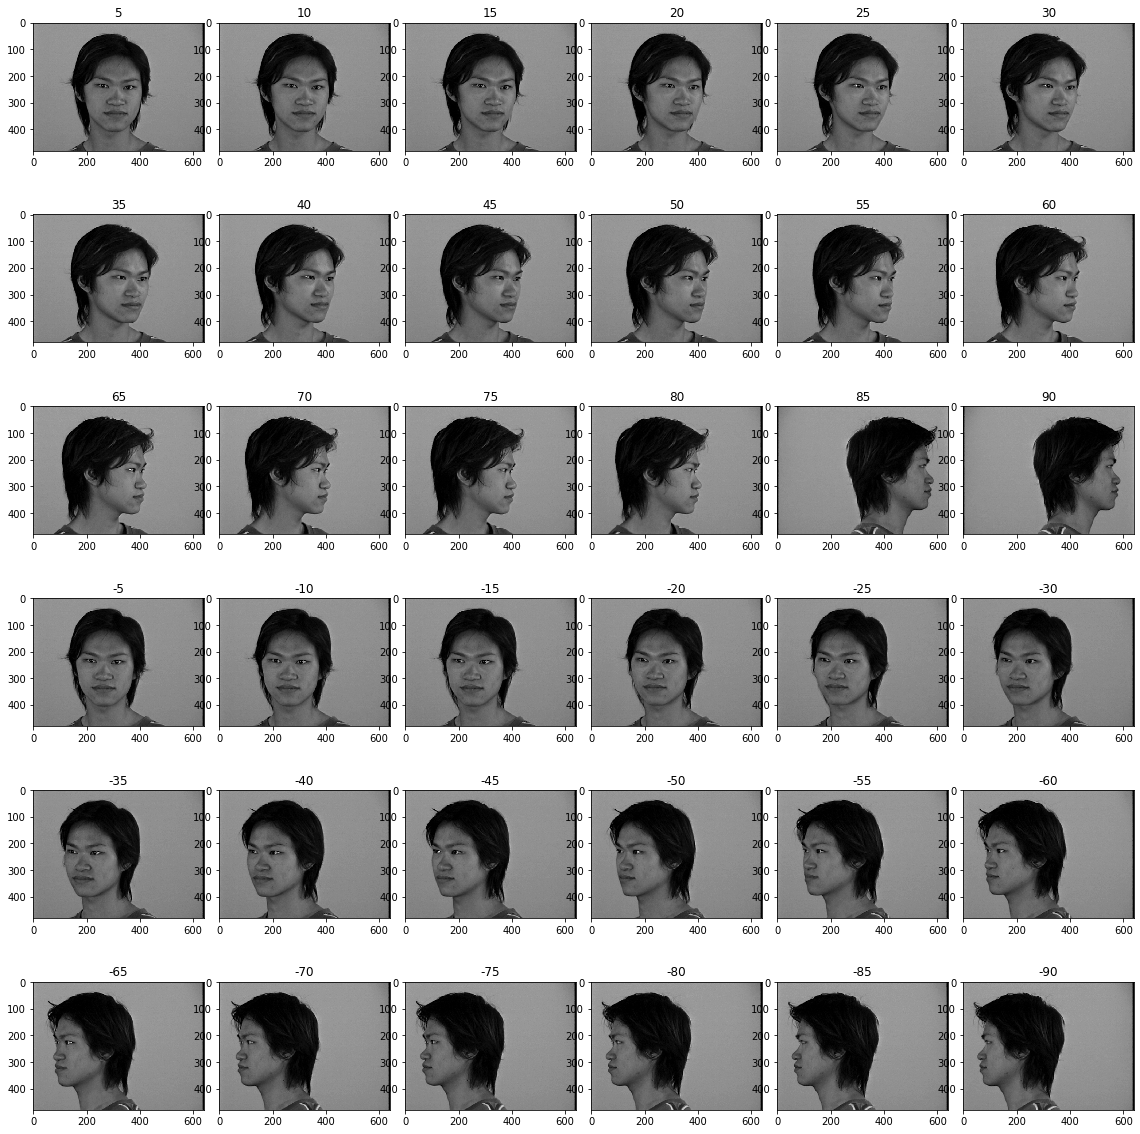

In [10]:
file_path=r'unzipped_data/'
fig, axs = plt.subplots(6,6, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(36):
    img_name=image_data.iloc[i].image_id
    label= image_data.iloc[i].angle
    img = cv2.imread(file_path+img_name)
    axs[i].imshow(img)
    axs[i].set_title(str(label))
plt.show()

In [11]:
img.shape

(480, 640, 3)

In [12]:
img.shape

(480, 640, 3)

#### Splitting data into train and test

In [13]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(image_data, test_size=0.2, random_state=42,shuffle= True)

#### Baseline model

In [24]:
tf.keras.backend.clear_session()

In [25]:
#import tensorflow as tf
from tensorflow.keras.layers import Flatten,Conv2D,Dense,MaxPooling2D
from tensorflow.keras import Model

In [26]:
#https://www.tensorflow.org/tutorials/images/transfer_learning
IMG_SHAPE=(150, 100, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet') # loading pretrained weights

In [27]:
base_model.trainable = False

In [28]:
x=base_model.output
layer1=Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0))(x)
layer2 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(layer1)

flatten= Flatten()(layer2)
dense1 = Dense(150, activation='relu')(flatten)
dense2 = Dense(30, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)
model = Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.keras.losses.MSE)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 25, 128)       0     

In [30]:
from PIL import Image

In [31]:
#https://keras.io/preprocessing/image/
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='unzipped_data',
        x_col="image_id",
        y_col="angle",
        target_size=(150,100),
        batch_size=32,
        class_mode='raw')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='unzipped_data',
        x_col="image_id",
        y_col="angle",
        target_size=(150,100),
        batch_size=32,
        class_mode='raw')



Found 5297 validated image filenames.
Found 1325 validated image filenames.


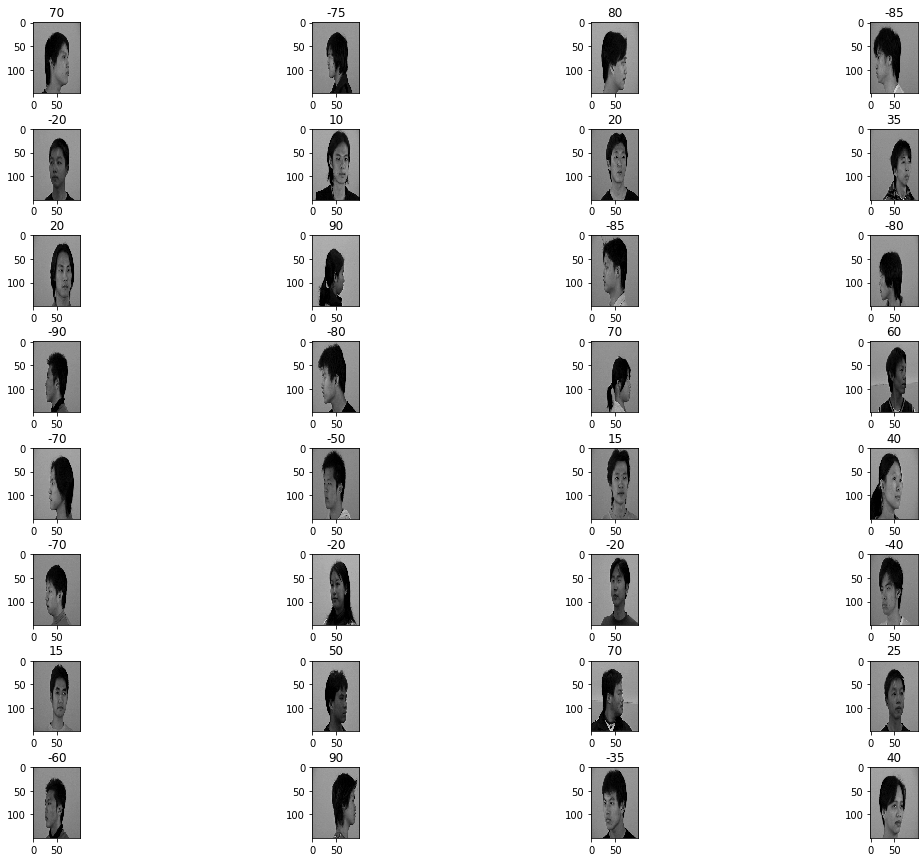

In [32]:
imgs,labels=validation_generator.next()
fig, axs = plt.subplots(8,4, figsize=(20, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(32):
    axs[i].imshow(imgs[i])
    axs[i].set_title(str(labels[i]))
plt.show()

In [33]:
model.fit_generator(
        train_generator,
        steps_per_epoch=train_data.shape[0]//32,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=test_data.shape[0]//32)

Epoch 1/10
165/165 [==============================] - 54s 328ms/step - loss: 889.9726 - val_loss: 218.6693
Epoch 2/10
165/165 [==============================] - 51s 310ms/step - loss: 174.6156 - val_loss: 112.9841
Epoch 3/10
165/165 [==============================] - 51s 310ms/step - loss: 99.6417 - val_loss: 70.1410
Epoch 4/10
165/165 [==============================] - 51s 310ms/step - loss: 79.0151 - val_loss: 65.3734
Epoch 5/10
165/165 [==============================] - 51s 309ms/step - loss: 63.9315 - val_loss: 84.1412
Epoch 6/10
165/165 [==============================] - 51s 309ms/step - loss: 59.4716 - val_loss: 50.8486
Epoch 7/10
165/165 [==============================] - 51s 308ms/step - loss: 54.1363 - val_loss: 49.8132
Epoch 8/10
165/165 [==============================] - 52s 315ms/step - loss: 47.7705 - val_loss: 60.6136
Epoch 9/10
165/165 [==============================] - 52s 314ms/step - loss: 41.5241 - val_loss: 43.0218
Epoch 10/10
165/165 [==============================

In [34]:
 model.save('weights.h5')

In [35]:
new_model = tf.keras.models.load_model('weights.h5')

In [36]:
new_model

In [51]:
img = cv2.imread('unzipped_data/B_18_-90.Jpg')

In [53]:
img.shape

(480, 640, 3)

In [58]:
img.shape

(150, 100, 3)

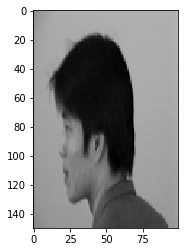

In [59]:
plt.imshow(img)

In [60]:
img = tf.keras.preprocessing.image.img_to_array(img)
img*=1./255
img = np.expand_dims(img, axis=0)

In [61]:
img.shape

(1, 150, 100, 3)

In [62]:
new_model.predict(img)

array([[-87.56394]], dtype=float32)

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]]

 [[163 163 163]
  [162 162 162]
  [159 159 159]
  ...
  [  3   3   3]
  [  3   3   3]
  [  1   1   1]]

 [[164 164 164]
  [162 162 162]
  [161 161 161]
  ...
  [  3   3   3]
  [  3   3   3]
  [  2   2   2]]

 ...

 [[143 143 143]
  [144 144 144]
  [139 139 139]
  ...
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]]

 [[144 144 144]
  [144 144 144]
  [139 139 139]
  ...
  [  1   1   1]
  [  0   0   0]
  [  0   0   0]]

 [[144 144 144]
  [144 144 144]
  [139 139 139]
  ...
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]]]


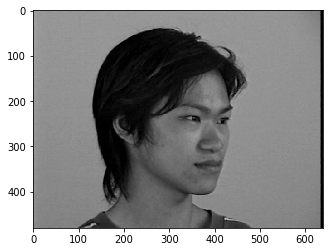

In [63]:
 from matplotlib import pyplot as plt
import cv2
img = cv2.imread('unzipped_data/A_01_+45.Jpg')
plt.imshow(img)
print(img)

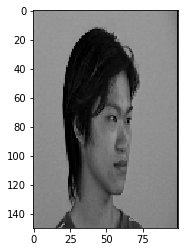

In [64]:
img=cv2.resize(img,(100,150))
plt.imshow(img)
img = tf.keras.preprocessing.image.img_to_array(img)
img*=1./255
img = np.expand_dims(img, axis=0)

In [65]:
model.predict(img)

array([[47.044964]], dtype=float32)

In [66]:
model.predict_generator(validation_generator)

array([[ 68.91652  ],
       [-75.61375  ],
       [ 89.882645 ],
       ...,
       [ 55.82624  ],
       [  6.2884865],
       [-34.263584 ]], dtype=float32)